In [1]:
import os

network_path = os.path.join("networks", "FS_SPN_feed_forward")

input_name = "FS_SPN_feed_forward"
sim_file_gj = os.path.join(network_path, "simulation", f"output-GJ-{input_name}.hdf5")
sim_file_nogj = os.path.join(network_path, "simulation", f"output-noGJ-{input_name}.hdf5")

input_config = f"{input_name}-input.json"
duration=3
osc_freq = 20

modified_network = os.path.join(network_path, "network-synapses-ablated.hdf5")

In [ ]:
from snudda.init import SnuddaInit

from snudda.init.init import SnuddaInit
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=1337,
                 snudda_data="../../../../BasalGangliaData/data/")
# To get only FS density we would use 0.013*80500, but then we also have dSPN and iSPN here in network
# so we need to compensate to get the correct FS neuron density (which is the important part)

num_FS = 40
num_dSPN_orig = 80
num_iSPN_orig = 80
num_dSPN_final = 10
num_iSPN_final = 10

cnc.define_striatum(num_dSPN=num_dSPN_orig, num_iSPN=num_iSPN_orig, num_FS=num_FS, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neuron_density=0.013*80500*(1 + (num_dSPN_orig + num_iSPN_orig)/num_FS))
cnc.add_population_unit_random("Striatum", "FS", 1.0, 1)
cnc.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

### Ablating network
It is important that the SPN networks receive a full set of FS inputs, so we want to only keep the SPN that are in the core.

In [ ]:
from snudda.utils import SnuddaLoad
from snudda.utils.ablate_network import SnuddaAblateNetwork
mod_network = SnuddaAblateNetwork(network_file=os.path.join(network_path, "network-synapses.hdf5"))
orig_sl = SnuddaLoad(network_path)
orig_fs_id = orig_sl.get_neuron_id_of_type("FS")
orig_dspn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=num_dSPN_final)]
orig_ispn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="iSPN", n_neurons=num_iSPN_final)]

keep_id = set(list(orig_fs_id) + list(orig_dspn_id) + list(orig_ispn_id)) 
mod_network.only_keep_neuron_id(keep_id)
mod_network.write_network(modified_network)

In [ ]:
from snudda.plotting.plot_network import PlotNetwork
pn = PlotNetwork(modified_network)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)

In [ ]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path,
                 hdf5_network_file=modified_network,
                 input_config_file=f"{input_name}-input.json",
                 verbose=False)
si.generate()

Loading 60 neurons with 1176 synapses and 145 gap junctions


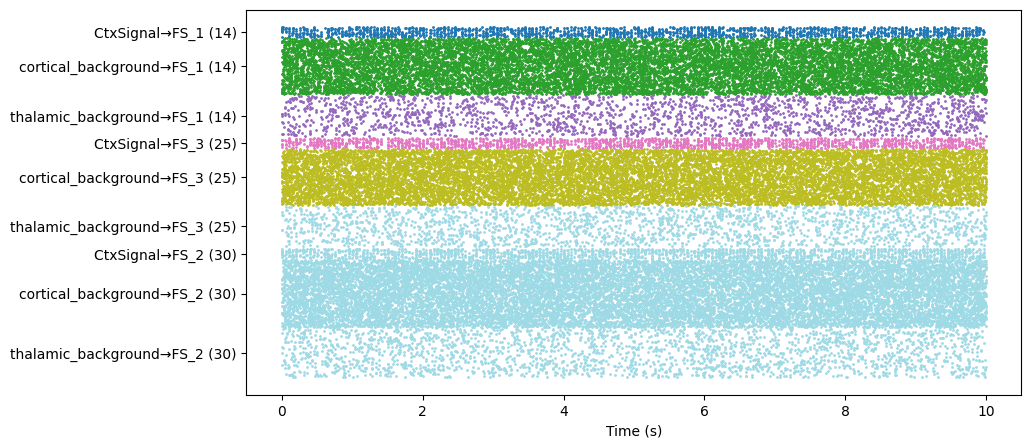

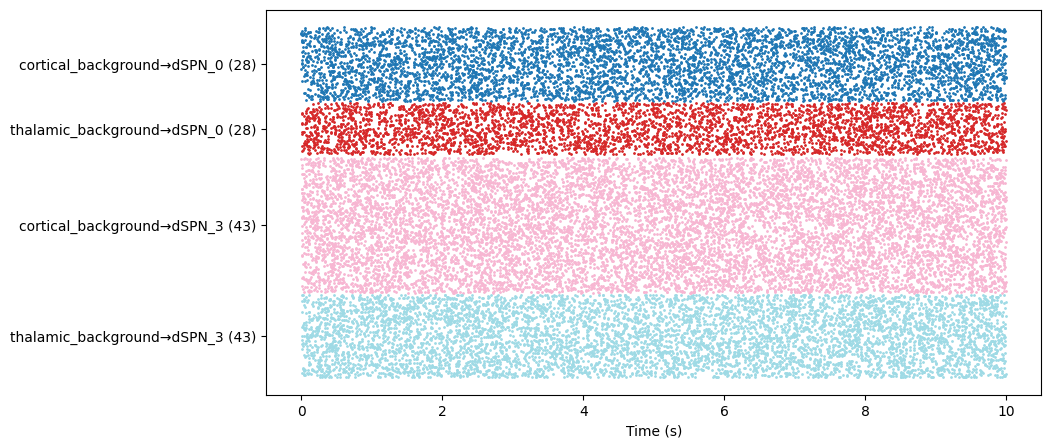

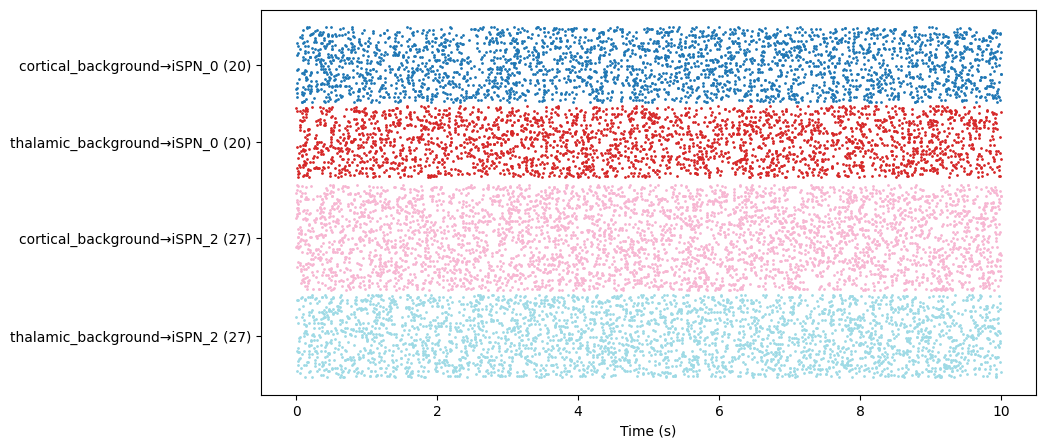

In [2]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file, network_path=modified_network)
spi.plot_input(neuron_type="FS", num_neurons=3)
spi.plot_input(neuron_type="dSPN", num_neurons=2)
spi.plot_input(neuron_type="iSPN", num_neurons=2)

In [3]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_gj}")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

0

In [ ]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_nogj} --disableGJ")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
Worker waiting for master node to compile NEURON modules.
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

Traceback (most recent call last):
  File "/home/hjorth/HBP/Snudda/venv/bin/snudda", line 33, in <module>
    sys.exit(load_entry_point('snudda', 'console_scripts', 'snudda')())
  File "/home/hjorth/HBP/Snudda/snudda/cli.py", line 186, in snudda_cli
    actions[args.action](args)
  File "/home/hjorth/HBP/Snudda/snudda/core.py", line 656, in simulate
    sim.write_output()
  File "/home/hjorth/HBP/Snudda/snudda/simulate/simulate.py", line 1581, in write_output
    self.record.write()
  File "/home/hjorth/HBP/Snudda/snudda/simulate/save_network_recording.py", line 325, in write
    self.write_header()
  File "/home/hjorth/HBP/Snudda/snudda/simulate/save_network_recording.py", line 289, in write_header
    out_file = h5py.File(self.output_file, "w")
  File "/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/h5py/_hl/files.py", line 533, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/h

In [ ]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network)
sls_gj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_gj)
sls_nogj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_nogj)

n_centre=10

nid_fs = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="FS")]
nid_dspn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="dSPN")]
nid_ispn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="iSPN")]

In [ ]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file_gj, network_file=modified_network)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

In [ ]:
from snudda.plotting.plot_traces import PlotTraces
pt2 = PlotTraces(output_file=sim_file_nogj, network_file=modified_network)
ax2 = pt2.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr = SnuddaPlotSpikeRaster2(network_path=network_path,
                             network_file=modified_network,
                             simulation_file=sim_file_gj,
                             snudda_load=sl, snudda_simulation_load=sls_gj)

ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, label="FS", color=spr.get_colours("FS"), show_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, label="iSPN", ax=ax, color=spr.get_colours("iSPN"))

In [ ]:
spr.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3, n_core=10)

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, 
                              network_file=modified_network,
                              simulation_file=sim_file_nogj,
                              snudda_load=sl, snudda_simulation_load=sls_nogj)

ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, label="FS", color=spr.get_colours("FS"), show_figure=False)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, label="iSPN", ax=ax, color=spr.get_colours("iSPN"))

In [ ]:
spr2.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3)